In [1]:
#!pip install numpy
#!pip install sklearn

In [1]:
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.pipeline import Pipeline
from scipy.fft import fft
import pywt
import scipy.stats as stats
import scipy.signal as signal
from itertools import combinations
random_seed = 100

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")

# TP2: Détection de menaces radar

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp2.ipynb 

2 séances de TP sur ce sujet : le 18 octobre (1h30) et le 25 octobre (3h).<br> 
Deadline : 8 novembre 2023, 11h59, par mail à deepetsignal.mva@gmail.com <br> 

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.
    
## Mission


Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence) 
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    
- train
- test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
    
    
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'. 

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante: 

- Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser 
- Sélection d'un algorithme naïf "baseline" de référence: vous définissez un premier algorithme simple et caractérisez ses performances qui serviront de point de comparaison pour qualifier l'apport d'algorithmes plus sophistiqués 
- Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
    
Pour ce TP nous ne cherchons pas à mettre en place des algorithmes d'apprentissage profond. Ces méthodes pourront être investiguées dans un deuxième temps.
    
 Si les résultats vous semblent décevants, souvenez vous des conseils de votre prédecesseur et mentor G. Abitbol: "toujours donner un coup de pouce à un algo de machine learning  en lui présentant les bonnes données"

Vous pouvez ouvrir un fichier de la façon suivante:

</div>    

In [42]:
pdws = np.load('./radars/train/pdw-0.npz')
dates = pdws['date']
largeurs = pdws['largeur']
frequences=pdws['puissance']
puissances = pdws['puissance']
theta = pdws['theta']
phi = pdws['phi']

<div class=consignes> et les fichiers d'annotations:</div>

In [43]:
import json

with open('./radars/train_labels.json') as f: 
    dict_labels = json.load(f)

with open('./radars/test_labels.json') as f: 
    dict_labels_test = json.load(f)

for i in range(10):
    print(f"Le signal pdw-{i}.npz est de type: {dict_labels[f'pdw-{i}']}")

Le signal pdw-0.npz est de type: nonmenace
Le signal pdw-1.npz est de type: nonmenace
Le signal pdw-2.npz est de type: menace
Le signal pdw-3.npz est de type: nonmenace
Le signal pdw-4.npz est de type: nonmenace
Le signal pdw-5.npz est de type: menace
Le signal pdw-6.npz est de type: menace
Le signal pdw-7.npz est de type: menace
Le signal pdw-8.npz est de type: menace
Le signal pdw-9.npz est de type: nonmenace


<div class=consignes> On compte sur vous, bonne chance ! </div>

# Data Loading

## Train Data Loading

In [44]:
dates = []
largeurs = []
frequences = []
puissances = []
theta = []
phi = []
labels = []

for i in range(2000):
    pdws = np.load(f'./radars/train/pdw-{i}.npz')
    dates.append(pdws['date'])
    largeurs.append(pdws['largeur'])
    frequences.append(pdws['frequence'])
    puissances.append(pdws['puissance'])
    theta.append(pdws['theta'])
    phi.append(pdws['phi'])
    if dict_labels[f'pdw-{i}'] == 'menace':
        labels.append(1)
    else:
        labels.append(0)

## Test Data Loading

In [45]:
test_dates = []
test_largeurs = []
test_frequences = []
test_puissances = []
test_theta = []
test_phi = []
test_labels = []

for i in range(800):
    pdws = np.load(f'./radars/test/pdw-{i}.npz')
    test_dates.append(pdws['date'])
    test_largeurs.append(pdws['largeur'])
    test_frequences.append(pdws['frequence'])
    test_puissances.append(pdws['puissance'])
    test_theta.append(pdws['theta'])
    test_phi.append(pdws['phi'])
    if dict_labels_test[f'pdw-{i}'] == 'menace':
        test_labels.append(1)
    else:
        test_labels.append(0)

In [46]:
diff_dates = []
for i in range(len(dates)):
    diff = np.diff(dates[i])
    diff_dates.append(diff)

for i in range(len(diff_dates)):
    diff_dates[i] = np.sort(diff_dates[i])

means_diff_d = []
variance_diff_d = []
min_diff_d = []
max_diff_d = []

# compute variance

for i in range(len(diff_dates)):
    variance_diff_d.append(np.var(diff_dates[i]))
    min_diff_d.append(np.min(diff_dates[i]))
    max_diff_d.append(np.max(diff_dates[i]))

# Keep the 300 first values of the sorted diff_dates

diff_dates = [diff_dates[i][:300] for i in range(len(diff_dates))]

# compute the mean of the 300 first values of the sorted diff_dates

for i in range(len(diff_dates)):
    means_diff_d.append(np.mean(diff_dates[i]))


# Same for the test set

test_diff_dates = []
for i in range(len(test_dates)):
    diff = np.diff(test_dates[i])
    test_diff_dates.append(diff)

for i in range(len(test_diff_dates)):
    test_diff_dates[i] = np.sort(test_diff_dates[i])

test_means_diff_d = []
test_variance_diff_d = []
test_min_diff_d = []
test_max_diff_d = []

for i in range(len(test_diff_dates)):
    test_variance_diff_d.append(np.var(test_diff_dates[i]))
    test_min_diff_d.append(np.min(test_diff_dates[i]))
    test_max_diff_d.append(np.max(test_diff_dates[i]))


test_diff_dates = [test_diff_dates[i][:300] for i in range(len(test_diff_dates))]

for i in range(len(test_diff_dates)):
    test_means_diff_d.append(np.mean(test_diff_dates[i]))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


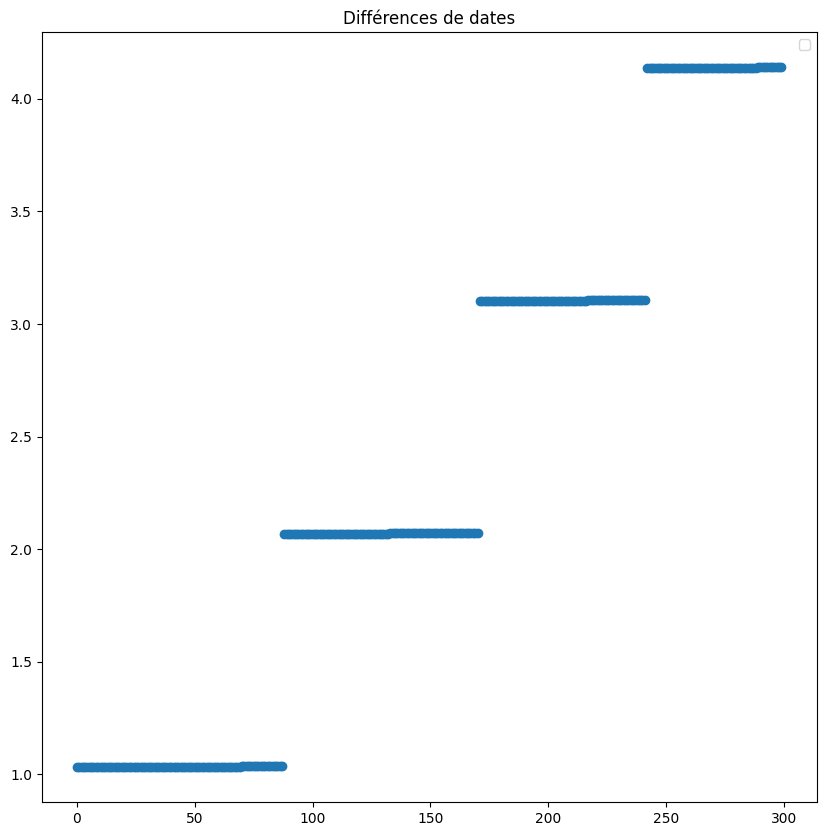

In [47]:
# Scatter plot of the diff_dates

plt.figure(figsize=(10,10))
plt.scatter(range(len(test_diff_dates[0])), test_diff_dates[0])
plt.title(f'Différences de dates')

plt.legend()
plt.show()

# Feature Engineering

* `Means:` average value of a set of data points

* `Variances:` spread or dispersion of data points

* `Maximum:` highest value of data points

* `Minimum:` lowest value of data points

* `Kurtosis:` shape of a probability distribution (tailedness)

* `Peak-to-Peak Amplitude:` the difference between the maximum and minimum values

* `Spectral Kurtosis:` shape of a frequency distribution

* `Mean Cross Rate:` quantifies how frequently a signal crosses its average value

* `Fourier Transformation:` represent functions or signals as a sum of sinusoidal functions (sine and cosine waves)

## Function to compute new features

In [48]:
def calculate_features(data):
    means = []
    variances = []
    maxs = []
    mins = []
    kurtosis = []
    ptp_amplitude = []
    spectral_kurtosis = []
    mean_cross_rate = []

    for i in range(len(data)):
        signal_i = data[i]
        means.append(np.mean(signal_i))
        variances.append(np.var(signal_i))
        maxs.append(np.max(signal_i))
        mins.append(np.min(signal_i))
        kurtosis.append(stats.kurtosis(signal_i))
        ptp_amplitude.append(np.ptp(signal_i))
        spectral_kurtosis.append(stats.kurtosis(np.abs(fft(signal_i))))
        mean_cross_rate.append(np.sum(np.diff(np.sign(signal_i - np.mean(signal_i))) != 0) / len(signal_i))

    return means, variances, maxs, mins, kurtosis, ptp_amplitude, spectral_kurtosis, mean_cross_rate

## Application to train data

In [49]:
means_puissances, variances_puissances, maxs_puissances, mins_puissances, kurtosis_puissances, ptp_amplitude_puissances, spectral_kurtosis_puissances, mean_cross_rate_puissances = calculate_features(puissances)
means_frequences, variances_frequences, maxs_frequences, mins_frequences, kurtosis_frequences, ptp_amplitude_frequences, spectral_kurtosis_frequences, mean_cross_rate_frequences = calculate_features(frequences)
means_largeurs, variances_largeurs, maxs_largeurs, mins_largeurs, kurtosis_largeurs, ptp_amplitude_largeurs, spectral_kurtosis_largeurs, mean_cross_rate_largeurs = calculate_features(largeurs)
means_theta, variances_theta, maxs_theta, mins_theta, kurtosis_theta, ptp_amplitude_theta, spectral_kurtosis_theta, mean_cross_rate_theta = calculate_features(theta)
means_phi, variances_phi, maxs_phi, mins_phi, kurtosis_phi, ptp_amplitude_phi, spectral_kurtosis_phi, mean_cross_rate_phi = calculate_features(phi)

In [50]:
features = [[means_puissances, variances_puissances, maxs_puissances, mins_puissances, kurtosis_puissances, ptp_amplitude_puissances, spectral_kurtosis_puissances, mean_cross_rate_puissances],
            [means_frequences, variances_frequences, maxs_frequences, mins_frequences, kurtosis_frequences, ptp_amplitude_frequences, spectral_kurtosis_frequences, mean_cross_rate_frequences],
            [means_largeurs, variances_largeurs, maxs_largeurs, mins_largeurs, kurtosis_largeurs, ptp_amplitude_largeurs, spectral_kurtosis_largeurs, mean_cross_rate_largeurs],
            [means_theta, variances_theta, maxs_theta, mins_theta, kurtosis_theta, ptp_amplitude_theta, spectral_kurtosis_theta, mean_cross_rate_theta],
            [means_phi, variances_phi, maxs_phi, mins_phi, kurtosis_phi, ptp_amplitude_phi, spectral_kurtosis_phi, mean_cross_rate_phi]]

## Application to test data

In [51]:
test_means_puissances, test_variances_puissances, test_maxs_puissances, test_mins_puissances, test_kurtosis_puissances, test_ptp_amplitude_puissances, test_spectral_kurtosis_puissances, test_mean_cross_rate_puissances = calculate_features(test_puissances)
test_means_frequences, test_variances_frequences, test_maxs_frequences, test_mins_frequences, test_kurtosis_frequences, test_ptp_amplitude_frequences, test_spectral_kurtosis_frequences, test_mean_cross_rate_frequences = calculate_features(test_frequences)
test_means_largeurs, test_variances_largeurs, test_maxs_largeurs, test_mins_largeurs, test_kurtosis_largeurs, test_ptp_amplitude_largeurs, test_spectral_kurtosis_largeurs, test_mean_cross_rate_largeurs = calculate_features(test_largeurs)
test_means_theta, test_variances_theta, test_maxs_theta, test_mins_theta, test_kurtosis_theta, test_ptp_amplitude_theta, test_spectral_kurtosis_theta, test_mean_cross_rate_theta = calculate_features(test_theta)
test_means_phi, test_variances_phi, test_maxs_phi, test_mins_phi, test_kurtosis_phi, test_ptp_amplitude_phi, test_spectral_kurtosis_phi, test_mean_cross_rate_phi = calculate_features(test_phi)

In [52]:
test_features = [[test_means_puissances, test_variances_puissances, test_maxs_puissances, test_mins_puissances, test_kurtosis_puissances, test_ptp_amplitude_puissances, test_spectral_kurtosis_puissances, test_mean_cross_rate_puissances],
            [test_means_frequences, test_variances_frequences, test_maxs_frequences, test_mins_frequences, test_kurtosis_frequences, test_ptp_amplitude_frequences, test_spectral_kurtosis_frequences, test_mean_cross_rate_frequences],
            [test_means_largeurs, test_variances_largeurs, test_maxs_largeurs, test_mins_largeurs, test_kurtosis_largeurs, test_ptp_amplitude_largeurs, test_spectral_kurtosis_largeurs, test_mean_cross_rate_largeurs],
            [test_means_theta, test_variances_theta, test_maxs_theta, test_mins_theta, test_kurtosis_theta, test_ptp_amplitude_theta, test_spectral_kurtosis_theta, test_mean_cross_rate_theta],
            [test_means_phi, test_variances_phi, test_maxs_phi, test_mins_phi, test_kurtosis_phi, test_ptp_amplitude_phi, test_spectral_kurtosis_phi, test_mean_cross_rate_phi]]

## Fourier Transformation

In [53]:
puissances_fft = []
test_puissances_fft = []

for i in range(len(puissances)):
    puissances_fft.append(np.abs(fft(puissances[i])))

for i in range(len(test_puissances)):
    test_puissances_fft.append(np.abs(fft(test_puissances[i])))

means_puissances_fft, variances_puissances_fft, maxs_puissances_fft, mins_puissances_fft, kurtosis_puissances_fft, ptp_amplitude_puissances_fft, spectral_kurtosis_puissances_fft, mean_cross_rate_puissances_fft = calculate_features(puissances_fft)
test_means_puissances_fft, test_variances_puissances_fft, test_maxs_puissances_fft, test_mins_puissances_fft, test_kurtosis_puissances_fft, test_ptp_amplitude_puissances_fft, test_spectral_kurtosis_puissances_fft, test_mean_cross_rate_puissances_fft = calculate_features(test_puissances_fft)

# Data Visualization

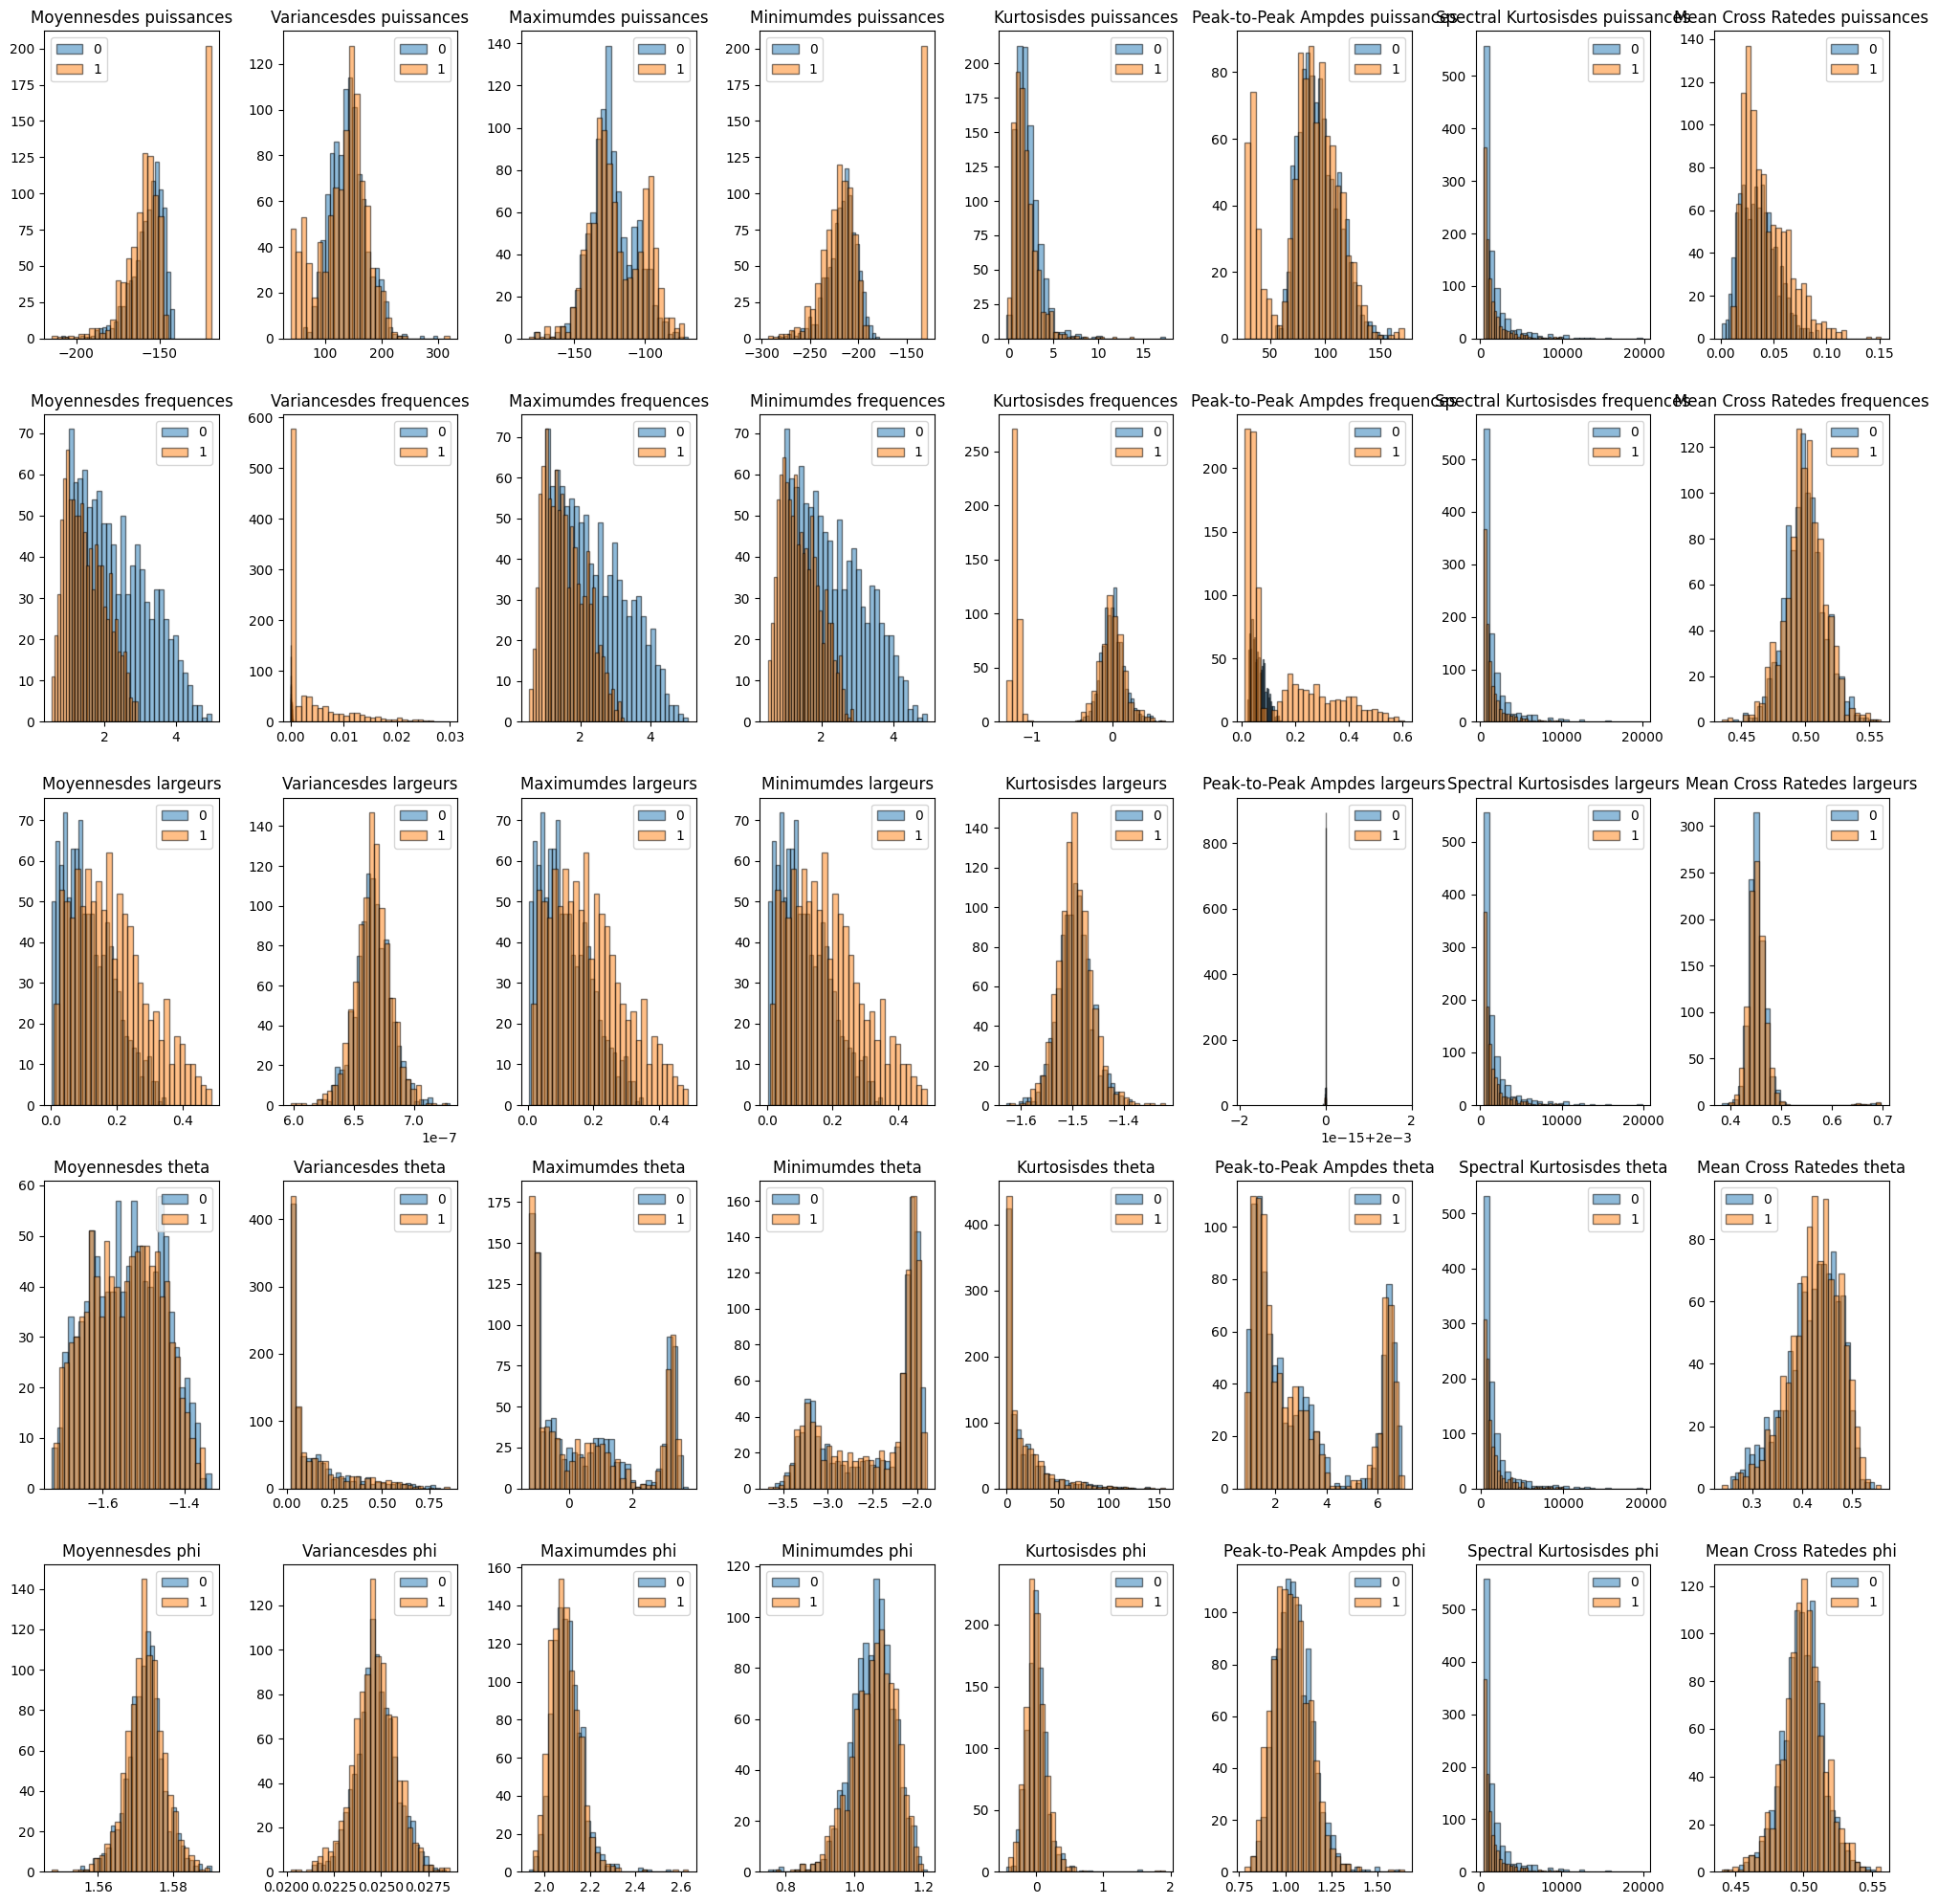

In [54]:
names_features = ["puissances", "frequences", "largeurs", "theta", "phi"]

plt.figure(figsize=(20,20))

for i in range(len(features)):
    
    for j in range(len(features[i])):
        plt.subplot(5,8,i*8+j+1)
        features_0 = [features[i][j][k] for k in range(len(features[i][j])) if labels[k] == 0]
        features_1 = [features[i][j][k] for k in range(len(features[i][j])) if labels[k] == 1]
        plt.hist(features_0, bins=30, alpha=0.5, label='0', edgecolor = 'black')
        plt.hist(features_1, bins=30, alpha=0.5, label='1', edgecolor = 'black')
        plt.title(f'{["Moyennes", "Variances", "Maximum", "Minimum", "Kurtosis", "Peak-to-Peak Amp", "Spectral Kurtosis", "Mean Cross Rate"][j]}' + f'des {names_features[i]}')
        plt.legend()
        plt.tight_layout()

plt.show()

* `Puissances:` Certain menace signals exhibit noticeable variations in mean values, accompanied by a discernible pattern of lower minimums and elevated maximums. These observations strongly suggest a substantial disparity in both peak-to-peak amplitude and mean cross rate within this context.

* `Frequences:` Non-menace signals exhibit higher means, maximums, minimums, and peak-to-peak. Conversely, menace signals show lower values in kurtosis.

* `Largeurs:` Menace signals demonstrate higher means, maximums, and minimums.

* `Theta & Phi:` The values are quite similar.

### Add the dates differences to the data

In [55]:
features.append([means_diff_d, variance_diff_d, min_diff_d, max_diff_d])
test_features.append([test_means_diff_d, test_variance_diff_d, test_min_diff_d, test_max_diff_d])

# Baseline Model

Our baseline model preprocesses the training and testing data by combining mean and variance frequencies into feature vectors. The model employs a basic thresholding rule, predicting class 1 (menace) if the mean frequency is below 3 and the variance frequency exceeds 0.001; otherwise, it predicts class 0 (non menace).

Accuracy of the baseline model: 71.15%


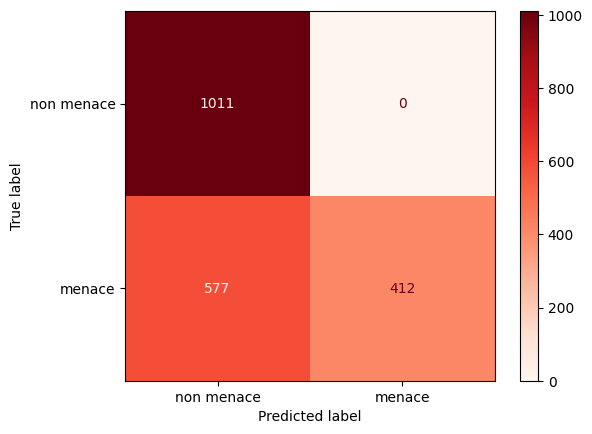

In [56]:
X_train = np.array([[means_frequences[i], variances_frequences[i]] for i in range(len(means_frequences))])
y_train = np.array(labels)

X_test = np.array([[test_means_frequences[i], test_variances_frequences[i]] for i in range(len(test_means_frequences))])
y_test = np.array(test_labels)

def baseline(X):
    predictions = []
    for i in range(len(X)):
        if X[i][0] < 3 and X[i][1] > 0.001:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

predictions = baseline(X_train)

print(f"Accuracy of the baseline model: {round(accuracy_score(y_train, predictions)*100, 2)}%")

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, predictions), display_labels=['non menace', 'menace'])

disp.plot(cmap=plt.cm.Reds)

plt.show()

Upon careful observation, it becomes evident that the baseline model consistently demonstrates a high degree of accuracy, accurately predicting non-menace signals with a commendable success rate consistently exceeding 70%. However, it is worth noting that its performance significantly falters when it comes to predicting menace signals. This discrepancy between its efficacy in handling non-menace versus menace signals highlights an area where improvement or specialized fine-tuning may be warranted for enhanced overall performance.

# Final Dataset

In [57]:
X_train = np.array([means_puissances, variances_puissances, maxs_puissances, mins_puissances, kurtosis_puissances, ptp_amplitude_puissances, spectral_kurtosis_puissances, mean_cross_rate_puissances,
                    means_frequences, variances_frequences, maxs_frequences, mins_frequences, kurtosis_frequences, ptp_amplitude_frequences, spectral_kurtosis_frequences, mean_cross_rate_frequences,
                    means_largeurs, variances_largeurs, maxs_largeurs, mins_largeurs, kurtosis_largeurs, ptp_amplitude_largeurs, spectral_kurtosis_largeurs, mean_cross_rate_largeurs,
                    means_theta, variances_theta, maxs_theta, mins_theta, kurtosis_theta, ptp_amplitude_theta, spectral_kurtosis_theta, mean_cross_rate_theta,
                    means_phi, variances_phi, maxs_phi, mins_phi, kurtosis_phi, ptp_amplitude_phi, spectral_kurtosis_phi, mean_cross_rate_phi,
                    means_puissances_fft, variances_puissances_fft, maxs_puissances_fft, mins_puissances_fft, kurtosis_puissances_fft, ptp_amplitude_puissances_fft, spectral_kurtosis_puissances_fft, mean_cross_rate_puissances_fft,
                    means_diff_d, variance_diff_d, min_diff_d, max_diff_d]).T

In [58]:
X_test = np.array([test_means_puissances, test_variances_puissances, test_maxs_puissances, test_mins_puissances, test_kurtosis_puissances, test_ptp_amplitude_puissances, test_spectral_kurtosis_puissances, test_mean_cross_rate_puissances,
                    test_means_frequences, test_variances_frequences, test_maxs_frequences, test_mins_frequences, test_kurtosis_frequences, test_ptp_amplitude_frequences, test_spectral_kurtosis_frequences, test_mean_cross_rate_frequences,
                    test_means_largeurs, test_variances_largeurs, test_maxs_largeurs, test_mins_largeurs, test_kurtosis_largeurs, test_ptp_amplitude_largeurs, test_spectral_kurtosis_largeurs, test_mean_cross_rate_largeurs,
                    test_means_theta, test_variances_theta, test_maxs_theta, test_mins_theta, test_kurtosis_theta, test_ptp_amplitude_theta, test_spectral_kurtosis_theta, test_mean_cross_rate_theta,
                    test_means_phi, test_variances_phi, test_maxs_phi, test_mins_phi, test_kurtosis_phi, test_ptp_amplitude_phi, test_spectral_kurtosis_phi, test_mean_cross_rate_phi,
                    test_means_puissances_fft, test_variances_puissances_fft, test_maxs_puissances_fft, test_mins_puissances_fft, test_kurtosis_puissances_fft, test_ptp_amplitude_puissances_fft, test_spectral_kurtosis_puissances_fft, test_mean_cross_rate_puissances_fft,
                    test_means_diff_d, test_variance_diff_d, test_min_diff_d, test_max_diff_d]).T

In [59]:
y_train = np.array(labels)

y_test = np.array(test_labels)

# Sophisticated Models

## Support Vector Machine

Accuracy of SVM: 55.38%


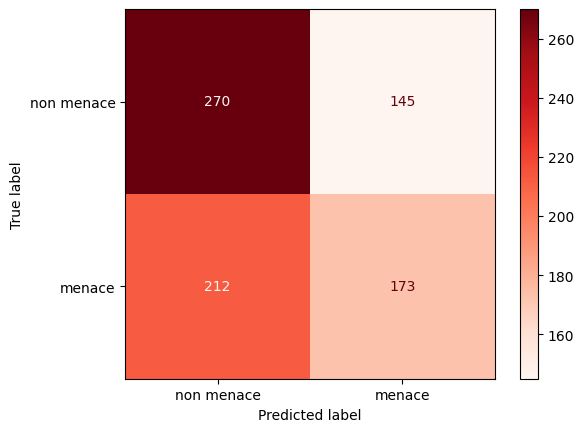

In [60]:
svm = SVC(random_state=random_seed)

svm.fit(X_train, y_train)

predictions = svm.predict(X_test)

accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy of SVM: {round(accuracy * 100, 2)}%")

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions), display_labels=['non menace', 'menace'])

disp.plot(cmap=plt.cm.Reds)

plt.show()

The SVM models, without fine-tuning, show quite poor accuracy. They make predictions worse than our baseline model. They definitely need some adjustments, especially in finding a good kernel. Taking time to fine-tune these SVM models is crucial for improving their performance.

## Ada Boost

AdaBoost is an ensemble learning technique that combines multiple weak classifiers to form a strong classifier, with each weak classifier giving more weight to misclassified data points in each iteration, ultimately creating a robust and accurate predictor.

Accuracy of Ada Boost: 86.75%


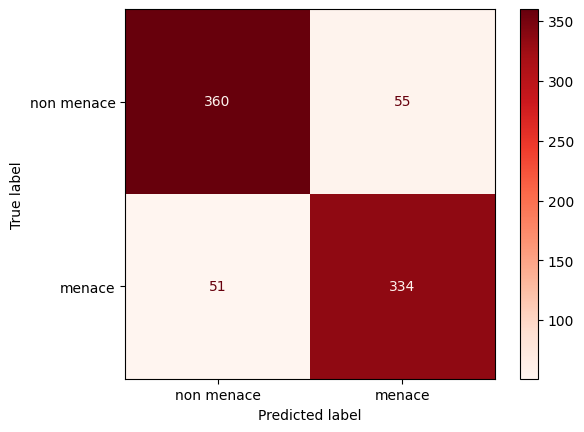

In [61]:
ada_boost = AdaBoostClassifier(random_state=random_seed)

ada_boost.fit(X_train, y_train)

predictions = ada_boost.predict(X_test)

accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy of Ada Boost: {round(accuracy * 100, 2)}%")

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions), display_labels=['non menace', 'menace'])

disp.plot(cmap=plt.cm.Reds)

plt.show()

Ada Boost outshines both the SVM models and the baseline due to its impressive accuracy exceeding 87%. It only makes mistakes for 102 signals. This shows its strength. With such a small number of errors, it's worth considering fine-tuning Ada Boost for even better performance in the model.

AdaBoost may outperform SVM in this context due to its ensemble nature. AdaBoost combines multiple weak learners (usually decision trees) to create a strong learner. Each weak learner focuses on the mistakes made by the previous ones, allowing the ensemble to learn complex patterns effectively. This adaptability and ability to capture intricate relationships in the data can lead to superior performance.

## Random Forest

Random Forest is an ensemble learning method that combines multiple decision trees to improve classification and regression tasks.

Accuracy of Random Forest: 89.12%


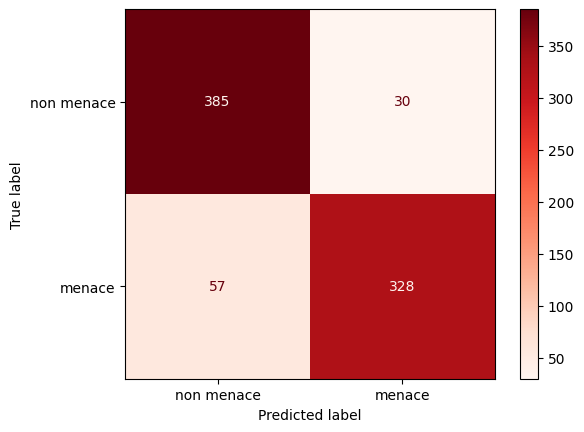

In [62]:
rf = RandomForestClassifier(random_state=random_seed)

rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy of Random Forest: {round(accuracy * 100, 2)}%")

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions), display_labels=['non menace', 'menace'])

disp.plot(cmap=plt.cm.Reds)

plt.show()

A Random Forest model impressively achieves an accuracy rate of 89%, showcasing its exceptional predictive prowess. This notable performance surpasses both AdaBoost and SVM models. The strength of Random Forest lies also in its ensemble approach, where it aggregates the predictions of multiple decision trees. This leads to a robust and versatile model that can capture intricate relationships within the data. 

# Feature Selection

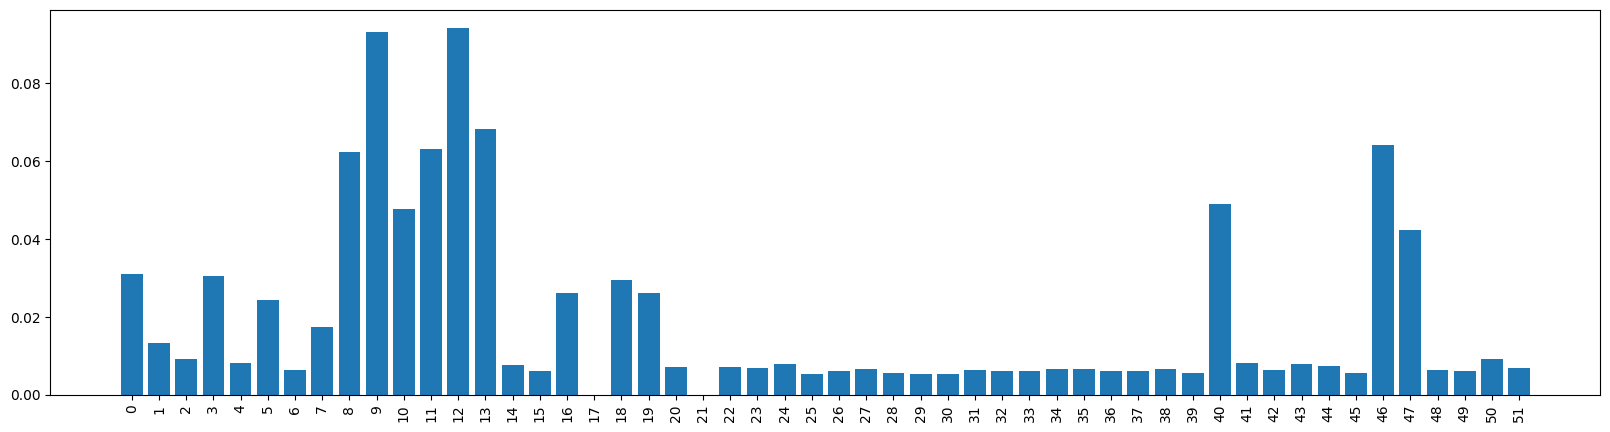

In [63]:
importances = rf.feature_importances_
plt.figure(figsize=(20,5))
plt.bar(range(X_train.shape[1]), importances)
plt.xticks(range(X_train.shape[1]), rotation=90)
plt.show()

We can see that some features don't affect the model much. To make a simpler model, even if it's a bit less accurate, we could just use the few really important features. This way, we can understand the model better and have a better model explainabilty for how it makes predictions.

In [64]:
rf = RandomForestClassifier(random_state=random_seed)

pipe = Pipeline([('select', SelectKBest()), ('model', rf)])

param_grid = {'select__k': range(1, len(X_train[0])+1)}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

grid.fit(X_train, y_train)

print(f"Best number of features: {grid.best_params_['select__k']}")

Best number of features: 34


In [65]:
selector = SelectKBest(k=grid.best_params_['select__k'])

selector.fit(X_train, y_train)

feature_names = ['means_puissances', 'variances_puissances', 'maxs_puissances', 'mins_puissances', 'kurtosis_puissances', 'ptp_amplitude_puissances', 'spectral_kurtosis_puissances', 'mean_cross_rate_puissances',
                    'means_frequences', 'variances_frequences', 'maxs_frequences', 'mins_frequences', 'kurtosis_frequences', 'ptp_amplitude_frequences', 'spectral_kurtosis_frequences', 'mean_cross_rate_frequences',
                    'means_largeurs', 'variances_largeurs', 'maxs_largeurs', 'mins_largeurs', 'kurtosis_largeurs', 'ptp_amplitude_largeurs', 'spectral_kurtosis_largeurs', 'mean_cross_rate_largeurs',
                    'means_theta', 'variances_theta', 'maxs_theta', 'mins_theta', 'kurtosis_theta', 'ptp_amplitude_theta', 'spectral_kurtosis_theta', 'mean_cross_rate_theta',
                    'means_phi', 'variances_phi', 'maxs_phi', 'mins_phi', 'kurtosis_phi', 'ptp_amplitude_phi', 'spectral_kurtosis_phi', 'mean_cross_rate_phi',
                    'means_puissances_fft', 'variances_puissances_fft', 'maxs_puissances_fft', 'mins_puissances_fft', 'kurtosis_puissances_fft', 'ptp_amplitude_puissances_fft', 'spectral_kurtosis_puissances_fft', 'mean_cross_rate_puissances_fft',
                    'means_diff_d', 'variance_diff_d', 'min_diff_d', 'max_diff_d']

best_features = []

for i in selector.get_support(indices=True):
    best_features.append(feature_names[i])

print(best_features)

['means_puissances', 'variances_puissances', 'maxs_puissances', 'mins_puissances', 'kurtosis_puissances', 'ptp_amplitude_puissances', 'spectral_kurtosis_puissances', 'mean_cross_rate_puissances', 'means_frequences', 'variances_frequences', 'maxs_frequences', 'mins_frequences', 'kurtosis_frequences', 'ptp_amplitude_frequences', 'spectral_kurtosis_frequences', 'means_largeurs', 'maxs_largeurs', 'mins_largeurs', 'spectral_kurtosis_largeurs', 'spectral_kurtosis_theta', 'maxs_phi', 'ptp_amplitude_phi', 'spectral_kurtosis_phi', 'variances_puissances_fft', 'maxs_puissances_fft', 'mins_puissances_fft', 'kurtosis_puissances_fft', 'ptp_amplitude_puissances_fft', 'spectral_kurtosis_puissances_fft', 'mean_cross_rate_puissances_fft', 'means_diff_d', 'variance_diff_d', 'min_diff_d', 'max_diff_d']


We can then tell that the best model we can achive is the one with only 30 features kepts since it's the feature that really have an impact on the accuracy of the prediction, meanwhile the other features have non or really low impact that can be neglected to gain in explicability.

## Fine-Tuned Random Forest

In order to achieve a better accuracy we make a Grid Search on the Random Forest models to find the hyperparameters that maximizes accuracy.

In [68]:
X_train_best = selector.transform(X_train)

X_test_best = selector.transform(X_test)

param_grid = {'n_estimators': np.arange(100, 300, 20),
                'max_depth': np.arange(1, 16, 2),
                'max_features': np.arange(1, 16, 2),
                'random_state': [random_seed]}


rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', verbose=0)

rf_grid.fit(X_train_best, y_train)

print(f"Best hyperparameters: {rf_grid.best_params_}")

print(f"Best accuracy: {round(rf_grid.score(X_test_best, y_test) * 100, 2)}%")

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions), display_labels=['non menace', 'menace'])

disp.plot(cmap=plt.cm.Reds)

plt.show()

In summary, with good feature engineering, feature selection and some hyper-parameter fine-tuning we achived a really good accuracy: mission completed!